# Level 1: Rice Crop Discovery Tool Benchmark Notebook

## Challenge Level 1 Overview

## Load In Dependencies

In [61]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import ipyleaflet
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score,classification_report,confusion_matrix

# Planetary Computer Tools
import pystac
import pystac_client
import odc
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
from odc.stac import stac_load
from odc.algo import to_rgba
from odc.stac import stac_load
import planetary_computer as pc
pc.settings.set_subscription_key('5621b92444c44ee48b55cf03c7dad3c1')

# Others
import requests
import rich.table
from itertools import cycle
from tqdm import tqdm
tqdm.pandas()

## Response Variable

In [67]:
crop_train_data = pd.read_csv("Crop_Location_Data_20221201_org.csv")
crop_train_data.tail()

,Latitude and Longitude,Class of Land
595,"(10.013942985253381, 105.67361318732796)",Non Rice
596,"(10.01348875642372, 105.67361318732796)",Non Rice
597,"(10.013034527594062, 105.67361318732796)",Non Rice
598,"(10.012580298764401, 105.67361318732796)",Non Rice
599,"(10.012126069934741, 105.67361318732796)",Non Rice


## Predictor Variables

In [68]:
def calculate_rvi(mean_vv, mean_vh):
    dop = (mean_vv / (mean_vv + mean_vh))
    m = 1 - dop
    rvi = (np.sqrt(dop)) * ((4 * mean_vh) / (mean_vv + mean_vh))
    return rvi
    

def get_sentinel_data(latlong,time_slice,assets):
    '''
    Returns VV and VH values for a given latitude and longitude 
    Attributes:
    latlong - A tuple with 2 elements - latitude and longitude
    time_slice - Timeframe for which the VV and VH values have to be extracted
    assets - A list of bands to be extracted
    '''

    latlong=latlong.replace('(','').replace(')','').replace(' ','').split(',')
    #bbox_of_interest = (float(latlong[1]) , float(latlong[0]), float(latlong[1]) , float(latlong[0]))
    box_size_deg = 0.00056 # Surrounding box in degrees, yields approximately 7x7 pixel region

    min_lon = float(float(latlong[1])-box_size_deg/2)
    min_lat = float(float(latlong[0])-box_size_deg/2)
    max_lon = float(float(latlong[1])+box_size_deg/2)
    max_lat = float(float(latlong[0])+box_size_deg/2)

    bbox_of_interest = (min_lon, min_lat, max_lon, max_lat)
    time_of_interest = time_slice

    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1"
    )
    search = catalog.search(
        collections=["sentinel-1-rtc"], bbox=bbox_of_interest, datetime=time_of_interest
    )
    items = list(search.get_all_items())
    bands_of_interest = assests
    data = stac_load([items[0]], patch_url=pc.sign, bbox=bbox_of_interest).isel(time=0)
    vh = data["vh"].astype("float").values.tolist()[0][0]
    vv = data["vv"].astype("float").values.tolist()[0][0]
    rvi = calculate_rvi(np.mean(vv), np.mean(vh))
    return vh,vv,rvi

In [69]:
def get_sentinel_data2(latlong, time_slice):
    '''
    Returns NDVI, SAVI, and EVI values for a given latitude and longitude 
    Attributes:
    latlong - A tuple with 2 elements - latitude and longitude
    time_slice - Timeframe for which the NDVI, SAVI, and EVI values have to be extracted
    '''

    latlong = latlong.replace('(', '').replace(')', '').replace(' ', '').split(',')
    
    box_size_deg = 0.1  

    # Calculate bounding box coordinates
    min_lon = float(float(latlong[1]) - box_size_deg / 2)
    min_lat = float(float(latlong[0]) - box_size_deg / 2)
    max_lon = float(float(latlong[1]) + box_size_deg / 2)
    max_lat = float(float(latlong[0]) + box_size_deg / 2)

    # Define the bounding box of interest
    bbox_of_interest = (min_lon, min_lat, max_lon, max_lat)
    time_of_interest = time_slice

    # Load Sentinel-2 data
    catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
    search = catalog.search(collections=["sentinel-2-l2a"], bbox=bbox_of_interest, datetime=time_of_interest)
    items = list(search.get_all_items())
    data = stac_load(
        [items[0]],
        bands=["red", "green", "blue", "nir", "SCL", "swir16"],
        crs="EPSG:4326",  # Latitude-Longitude
        resolution=20 / 111320.0,  # Degrees
        chunks={"x": 2048, "y": 2048},
        dtype="uint16",
        patch_url=pc.sign,
        bbox=bbox_of_interest
    ).isel(time=0)

    # Extract required bands
    mean_unfiltered = data.mean(dim=['longitude','latitude']).compute()
    ndvi = (mean_unfiltered.nir - mean_unfiltered.red) / (mean_unfiltered.nir + mean_unfiltered.red)
    
    l1 = 0.5
    savi = ((mean_unfiltered.nir - mean_unfiltered.red) / (mean_unfiltered.nir + mean_unfiltered.red + l1)) * (1 + l1)
    
    l = 1.0
    c1 = 6.0
    c2 = 7.5
    evi = 2.5 * ((mean_unfiltered.nir - mean_unfiltered.red) / (mean_unfiltered.nir + c1 * mean_unfiltered.red - c2 * mean_unfiltered.blue + l))

    albedo = 0.356 * mean_unfiltered.blue + 0.130 * mean_unfiltered.green + 0.373 * mean_unfiltered.red + 0.085 * mean_unfiltered.nir + 0.072 * mean_unfiltered.swir16 +0.0018 

    return ndvi.item(), savi.item(), evi.item(), albedo.item()

In [ ]:
## Get Sentinel-1-RTC Data
time_slice = "2022-12-01/2024-03-20"
assests = ['vh','vv']
vh_vv = []
for coordinates in tqdm(crop_train_data['Latitude and Longitude']):
    vh_vv.append(get_sentinel_data(coordinates,time_slice,assests))
vh_vv_data = pd.DataFrame(vh_vv,columns =['vh','vv','rvi'])

In [ ]:
## Function call to extract VV,VH Values
time_slice = "2022-12-01/2024-03-20"
ndvi_savi_evi_albedo = []
for coordinates in tqdm(crop_train_data['Latitude and Longitude']):
    ndvi_savi_evi_albedo.append(get_sentinel_data2(coordinates,time_slice))
ndvi_savi_evi_albedo_data = pd.DataFrame(ndvi_savi_evi_albedo,columns =['ndvi','savi','evi','albedo'])

In [52]:
vh_vv_data.tail()

,vh,vv,rvi
595,0.049336,0.141694,0.889711
596,0.039267,0.063976,1.197584
597,0.133557,0.263397,1.096282
598,0.081896,0.142046,1.165024
599,0.037517,0.193375,0.594801


In [16]:
ndvi_savi_evi_albedo_data.head()

,ndvi,savi,evi,albedo
0,0.302316,0.453438,1.103692,2283.164623
1,0.302123,0.453147,1.106074,2253.582363
2,0.302281,0.453384,1.099707,2285.776173
3,0.302208,0.453275,1.103770,2282.715433
4,0.302684,0.453988,1.102071,2261.597149


## Joining the predictor variables and response variables
Now that we have extracted our predictor variables, we need to join them onto the response variable . We use the function <i><b>combine_two_datasets</b></i> to combine the predictor variables and response variables.The <i><b>concat</b></i> function from pandas comes in handy here.

In [17]:
def combine_all_datasets(data1,data2,data3):
    merged_data = pd.concat([data1,data2,data3], axis=1)
    return merged_data

In [18]:
final_data = combine_all_datasets(crop_train_data,vh_vv_data,ndvi_savi_evi_albedo_data)
final_data.tail()

,Latitude and Longitude,Class of Land,vh,vv,rvi,ndvi,savi,evi,albedo
595,"(10.013942985253381, 105.67361318732796)",Non Rice,0.052538,0.273019,0.591138,0.414787,0.622125,2.245775,1931.546659
596,"(10.01348875642372, 105.67361318732796)",Non Rice,0.061710,0.346578,0.557014,0.415254,0.622826,2.247774,1930.865753
597,"(10.013034527594062, 105.67361318732796)",Non Rice,0.093156,0.178609,1.111556,0.415820,0.623675,2.250099,1930.043236
598,"(10.012580298764401, 105.67361318732796)",Non Rice,0.062540,0.268455,0.680646,0.416233,0.624294,2.252151,1929.522602
599,"(10.012126069934741, 105.67361318732796)",Non Rice,0.075619,0.238131,0.839889,0.416776,0.625108,2.255144,1928.746698


In [19]:
final_data.to_csv('output.csv', index=False)

In [74]:
final_data = pd.read_csv('output (1).csv')

## Model Building


<p align="justify"> Now let us select the columns required for our model building exercise. We will consider only VV and VH for our model. It does not make sense to use latitude and longitude as predictor variables as they do not have any impact on presence of rice crop.</p>

### Train and Test Split 

<p align="justify">We will now split the data into 70% training data and 30% test data. Scikit-learn alias “sklearn” is a robust library for machine learning in Python. The scikit-learn library has a <i><b>model_selection</b></i> module in which there is a splitting function <i><b>train_test_split</b></i>. You can use the same.</p>

In [78]:
# Split the data into features (X) and target variable (y)
X = final_data[['vh', 'vv', 'rvi', 'ndvi', 'savi', 'evi', 'albedo']]
y = final_data['Class of Land']

# Encode the target variable
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

### Feature Scaling 

In [79]:
from sklearn.preprocessing import MinMaxScaler
mc = MinMaxScaler()
X_train = mc.fit_transform(X_train)
X_test = mc.transform(X_test)

In [80]:
from sklearn.preprocessing import RobustScaler
rc = RobustScaler()
X_train = rc.fit_transform(X_train)
X_test = rc.transform(X_test)

In [81]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [83]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Suppress ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Split the data into training and testing sets
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Define the pipelines with different scalers and Logistic Regression
pipelines = {
    'StandardScaler': Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression(max_iter=1000, solver='lbfgs'))]),
    'RobustScaler': Pipeline([('scaler', RobustScaler()), ('lr', LogisticRegression(max_iter=1000, solver='lbfgs'))]),
    'MinMaxScaler': Pipeline([('scaler', MinMaxScaler()), ('lr', LogisticRegression(max_iter=1000, solver='lbfgs'))])
}

# Define the hyperparameter grid for GridSearchCV
param_grid = {
    'lr__C': [0.001, 0.01, 0.1, 1, 10, 100, 500, 1000],  # Regularization strength
}

# Perform hyperparameter tuning and evaluation for each scaler
results = {}
for scaler_name, pipeline in pipelines.items():
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5)
    grid_search.fit(X_train, y_train_encoded)
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    best_model.fit(X_train, y_train_encoded)
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test_encoded, y_pred)
    results[scaler_name] = {'Accuracy': accuracy, 'Best Hyperparameters': best_params}

# Print the results
for scaler_name, result in results.items():
    print(f'{scaler_name}:')
    print(f'Accuracy: {result["Accuracy"]:.4f}')
    print(f'Best Hyperparameters: {result["Best Hyperparameters"]}')
    print()


StandardScaler:
Accuracy: 0.8833
Best Hyperparameters: {'lr__C': 100}

RobustScaler:
Accuracy: 0.8750
Best Hyperparameters: {'lr__C': 500}

MinMaxScaler:
Accuracy: 0.8833
Best Hyperparameters: {'lr__C': 500}



### Model Training

<p justify ="align">Now that we have the data in a format appropriate for machine learning, we can begin training a model. In this demonstration notebook, we have used a binary logistic regression model from the scikit-learn library. This library offers a wide range of other models, each with the capacity for extensive parameter tuning and customization capabilities.</p>

<p justify ="align">Scikit-learn models require separation of predictor variables and the response variable. You have to store the predictor variables in array X and the response variable in the array Y. You must make sure not to include the response variable in array X. It also doesn't make sense to use latitude and longitude as predictor variables in such a confined area, so we drop those too.</p>

In [88]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

# Assuming X and y_encoded are already defined
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Define list of classifiers with hyperparameters
# Define list of classifiers with hyperparameters
classifiers = [
    ('Logistic Regression', LogisticRegression(max_iter=1000), {'classifier__C': [0.1, 1, 10]}),
    ('Random Forest', RandomForestClassifier(), {'classifier__n_estimators': [50, 100, 200], 'classifier__max_depth': [None, 5, 10]}),
    ('Gradient Boosting', GradientBoostingClassifier(), {'classifier__n_estimators': [50, 100, 200], 'classifier__max_depth': [3, 5, 7], 'classifier__learning_rate': [0.1, 0.5, 1.0]}),
    ('AdaBoost', AdaBoostClassifier(), {'classifier__n_estimators': [50, 100, 200], 'classifier__learning_rate': [0.1, 0.5, 1.0]}),
    ('SVM', SVC(), {'classifier__C': [0.1, 1, 10], 'classifier__kernel': ['linear', 'rbf']}),
    ('KNN', KNeighborsClassifier(), {'classifier__n_neighbors': [3, 5, 7]}),
    ('Naive Bayes', GaussianNB(), {})
]

results = []

# Loop through each classifier, perform grid search and evaluate accuracy
for name, model, param_grid in classifiers:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])
    
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5)
    grid_search.fit(X_train, y_train_encoded)
    best_model = grid_search.best_estimator_
    accuracy = accuracy_score(y_test_encoded, best_model.predict(X_test))
    results.append((name, grid_search.best_params_, accuracy))

# Print the results sorted by accuracy score
results.sort(key=lambda x: x[2], reverse=True)
for name, params, accuracy in results:
    print(f'{name}: Accuracy = {accuracy:.4f}, Best Params = {params}')

Random Forest: Accuracy = 1.0000, Best Params = {'classifier__max_depth': None, 'classifier__n_estimators': 50}
Gradient Boosting: Accuracy = 1.0000, Best Params = {'classifier__learning_rate': 1.0, 'classifier__max_depth': 7, 'classifier__n_estimators': 200}
AdaBoost: Accuracy = 1.0000, Best Params = {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 50}
SVM: Accuracy = 1.0000, Best Params = {'classifier__C': 0.1, 'classifier__kernel': 'rbf'}
KNN: Accuracy = 1.0000, Best Params = {'classifier__n_neighbors': 3}
Logistic Regression: Accuracy = 0.8833, Best Params = {'classifier__C': 10}
Naive Bayes: Accuracy = 0.7750, Best Params = {}


When comparing the performance of different machine learning models, it's essential to consider not just the accuracy but also factors like overfitting and the characteristics of the dataset. In your case, several models are showing perfect accuracy (1.0000), which could indicate potential overfitting. However, Logistic Regression and Naive Bayes, while not achieving the highest accuracy, are not exhibiting signs of overfitting and can be further explored for the following reasons:

Logistic Regression (Accuracy = 0.8833):
Best Params: {'classifier__C': 10}
Logistic Regression is a linear model that works well for binary classification tasks.
It provides interpretable results and is less prone to overfitting compared to more complex models.
The regularization parameter (C=10) helps control overfitting by penalizing large coefficients.

Naive Bayes (Accuracy = 0.7750):
Best Params: {}
Naive Bayes is a probabilistic classifier based on Bayes' theorem and assumes independence among features.
It performs well with categorical and text data, making it suitable for certain types of datasets.
Despite not having hyperparameters to tune, Naive Bayes is simple and often robust against overfitting.

While Random Forest, Gradient Boosting, AdaBoost, SVM, and KNN are showing perfect accuracy, they may be overfitting the training data, especially since the dataset is small. So we work with Logistic Regression and Naive Bayes, with their simplicity and regularization mechanisms, which can be further refined and explored to achieve a balance between accuracy and generalization on unseen data.

In [89]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Suppress ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Split the data into training and testing sets
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Define the pipeline with StandardScaler and Logistic Regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=1000, solver='lbfgs'))  # Use 'lbfgs' solver with 'l2' penalty
])

# Define the hyperparameter grid for GridSearchCV
param_grid = {
    'lr__C': [0.001, 0.01, 0.1, 1, 10, 100, 500],  # Regularization strength
}

# Perform hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train_encoded)

# Get the best hyperparameters and their corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Train the best model on the entire training data
best_model.fit(X_train, y_train_encoded)

# Evaluate the model on the testing data
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f'Logistic Regression Accuracy: {accuracy:.4f}')
print(f'Best Hyperparameters: {best_params}')

Logistic Regression Accuracy: 0.8833
Best Hyperparameters: {'lr__C': 100}


**Feature Engineering**

In [91]:
 # Feature Engineering
X_train_new = X_train.copy()
X_test_new = X_test.copy()

# Example feature engineering (you can add more as needed)
X_train_new['vh_squared'] = X_train_new['vh'] ** 2
X_test_new['vh_squared'] = X_test_new['vh'] ** 2

X_train_new['vv_log'] = np.log(X_train_new['vv'])
X_test_new['vv_log'] = np.log(X_test_new['vv'])

In [92]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline


# Define the pipeline with StandardScaler and Logistic Regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=1000))
])

# Define the hyperparameter grid for GridSearchCV
param_grid = {
    'lr__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'lr__penalty': ['l1', 'l2']  # Regularization type
}

# Perform hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5)
grid_search.fit(X_train_new, y_train_encoded)

# Get the best hyperparameters and their corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Train the best model on the entire training data
best_model.fit(X_train_new, y_train_encoded)

# Evaluate the model on the testing data
y_pred = best_model.predict(X_test_new)
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f'Logistic Regression Accuracy: {accuracy:.4f}')
print(f'Best Hyperparameters: {best_params}')

Logistic Regression Accuracy: 0.9333
Best Hyperparameters: {'lr__C': 1, 'lr__penalty': 'l2'}


## Model Evaluation

Now that we have trained our model , all that is left is to evaluate it. For evaluation we will generate the classification report and will plot the confusion matrix. Scikit-learn provides many other metrics that can be used for evaluation. You can even write a code on your own.

### In-Sample and Out-of-sample Evaluation
<p align="Jutisfy"> We will be generating a classification report and a confusion matrix for the training data. It must be stressed that this is in-sample performance testing , which is the performance testing on the training dataset. These metrics are NOT truly indicative of the model's performance. You should wait to test the model performance on the test data before you feel confident about your model.</p>

In this section, we make predictions on the training set and store them in the <b><i>insample_ predictions</i></b> variable. A confusion matrix is generated to gauge the robustness of the model. 

In [99]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# In-sample evaluation
insample_predictions = best_model.predict(X_train_new)
insample_accuracy = accuracy_score(y_train_encoded, insample_predictions)
insample_precision = precision_score(y_train_encoded, insample_predictions)
insample_recall = recall_score(y_train_encoded, insample_predictions)
insample_f1 = f1_score(y_train_encoded, insample_predictions)
insample_roc_auc = roc_auc_score(y_train_encoded, insample_predictions)

print('In-sample Evaluation:')
print(f'Accuracy: {insample_accuracy:.4f}')
print(f'Precision: {insample_precision:.4f}')
print(f'Recall: {insample_recall:.4f}')
print(f'F1 Score: {insample_f1:.4f}')
print(f'ROC AUC Score: {insample_roc_auc:.4f}')

# Out-of-sample evaluation
outsample_predictions = best_model.predict(X_test_new)
outsample_accuracy = accuracy_score(y_test_encoded, outsample_predictions)
outsample_precision = precision_score(y_test_encoded, outsample_predictions)
outsample_recall = recall_score(y_test_encoded, outsample_predictions)
outsample_f1 = f1_score(y_test_encoded, outsample_predictions)
outsample_roc_auc = roc_auc_score(y_test_encoded, outsample_predictions)

print('\nOut-of-sample Evaluation:')
print(f'Accuracy: {outsample_accuracy:.4f}')
print(f'Precision: {outsample_precision:.4f}')
print(f'Recall: {outsample_recall:.4f}')
print(f'F1 Score: {outsample_f1:.4f}')
print(f'ROC AUC Score: {outsample_roc_auc:.4f}')



In-sample Evaluation:
Accuracy: 0.8833
Precision: 0.8555
Recall: 0.9202
F1 Score: 0.8866
ROC AUC Score: 0.8836

Out-of-sample Evaluation:
Accuracy: 0.9333
Precision: 0.8857
Recall: 1.0000
F1 Score: 0.9394
ROC AUC Score: 0.9310


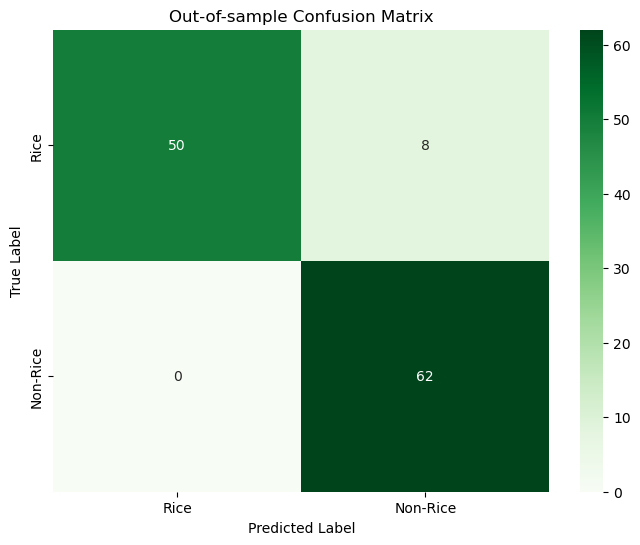

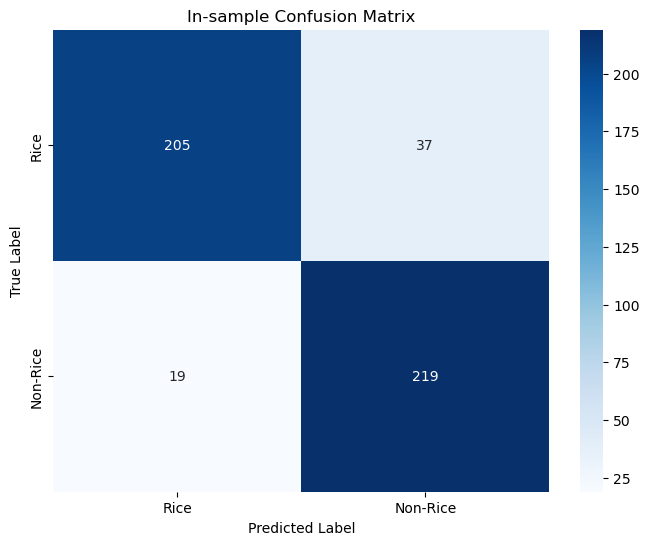

In [102]:
# Confusion matrix for out-of-sample predictions
labels = ['Rice', 'Non-Rice']
conf_matrix_outsample = confusion_matrix(y_test_encoded, outsample_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_outsample, annot=True, fmt='d', cmap='Greens')
plt.xticks(ticks=[0.5, 1.5], labels=labels)
plt.yticks(ticks=[0.5, 1.5], labels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Out-of-sample Confusion Matrix')
plt.show()

# Confusion matrix for in-sample predictions
insample_predictions = best_model.predict(X_train_new)
conf_matrix_insample = confusion_matrix(y_train_encoded, insample_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_insample, annot=True, fmt='d', cmap='Blues')
plt.xticks(ticks=[0.5, 1.5], labels=labels)
plt.yticks(ticks=[0.5, 1.5], labels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('In-sample Confusion Matrix')
plt.show()


## Submission

Once you are happy with your model, you can make a submission. To make a submission, you will need to use your model to make predictions about the presence of rice crops for a set of test coordinates we have provided in the <a href="https://challenge.ey.com/api/v1/storage/admin-files/6847912254281276-63ca8b5ab12e510013520e2b-challenge_1_submission_template.csv"><b>"challenge_1_submission_template.csv"</b></a> file and upload the file onto the challenge platform.

In [103]:
#Reading the coordinates for the submission
test_file = pd.read_csv('challenge_1_submission_template.csv')
test_file.head()

,Latitude and Longitude
0,"(10.18019073690894, 105.32022315786804)"
1,"(10.561107033461816, 105.12772097986661)"
2,"(10.623790611954897, 105.13771401411867)"
3,"(10.583364246115156, 105.23946127195805)"
4,"(10.20744446668854, 105.26844107128906)"


In [106]:
## Get Sentinel-1-RTC Data
time_slice = "2022-12-01/2024-03-20"
assests = ['vh','vv']
vh_vv = []
for coordinates in tqdm(test_file['Latitude and Longitude']):
    vh_vv.append(get_sentinel_data(coordinates,time_slice,assests))
vh_vv_data_submission = pd.DataFrame(vh_vv,columns =['vh','vv','rvi'])

100%|██████████| 250/250 [01:11<00:00,  3.52it/s]


In [107]:
vh_vv_data_submission.tail() 

,vh,vv,rvi
245,0.005842,0.013942,0.991575
246,0.012744,0.015107,1.348023
247,0.003662,0.019544,0.579308
248,0.013899,0.144183,0.335871
249,0.032755,0.099469,0.859450


In [108]:
## Function call to extract VV,VH Values
time_slice = "2022-12-01/2024-03-20"
ndvi_savi_evi_albedo = []
for coordinates in tqdm(test_file['Latitude and Longitude']):
    ndvi_savi_evi_albedo.append(get_sentinel_data2(coordinates,time_slice))
ndvi_savi_evi_albedo_data_submission = pd.DataFrame(ndvi_savi_evi_albedo,columns =['ndvi','savi','evi','albedo'])

100%|██████████| 250/250 [02:58<00:00,  1.40it/s]


In [ ]:
ndvi_savi_evi_albedo_data_submission.tail() 

In [126]:
merged_submission_data = combine_all_datasets(test_file,vh_vv_data_submission,ndvi_savi_evi_albedo_data_submission)
merged_submission_data.tail()

,Latitude and Longitude,vh,vv,rvi,ndvi,savi,evi,albedo
245,"(10.308283266873062, 105.50872812216863)",0.005842,0.013942,0.991575,0.252923,0.379347,1.752295,2022.427450
246,"(10.582910017285496, 105.23991550078767)",0.012744,0.015107,1.348023,0.277897,0.416809,1.308196,2129.853726
247,"(10.581547330796518, 105.23991550078767)",0.003662,0.019544,0.579308,0.280466,0.420661,1.314948,2131.962951
248,"(10.629241357910818, 105.15315779432643)",0.013899,0.144183,0.335871,0.322383,0.483532,1.551768,2153.312151
249,"(10.574733898351617, 105.10410108072531)",0.032755,0.099469,0.859450,0.273193,0.409752,1.287401,2140.936498


In [127]:
merged_submission_data.drop(columns=['Latitude and Longitude'], inplace=True)
final_merge = merged_submission_data  

In [138]:
final_merge

,vh,vv,rvi,ndvi,savi,evi,albedo
0,0.061296,0.076820,1.323926,0.122967,0.184429,1.075772,1901.101410
1,0.025312,0.036651,1.256703,0.273995,0.410956,1.305927,2117.997680
2,0.032175,0.107747,0.807148,0.320559,0.480797,1.532261,2151.270543
3,0.004751,0.011246,0.996113,0.277820,0.416692,1.308142,2129.433131
4,0.002766,0.032487,0.301312,0.140848,0.211249,0.910392,1957.652617
...,...,...,...,...,...,...,...
245,0.005842,0.013942,0.991575,0.252923,0.379347,1.752295,2022.427450
246,0.012744,0.015107,1.348023,0.277897,0.416809,1.308196,2129.853726
247,0.003662,0.019544,0.579308,0.280466,0.420661,1.314948,2131.962951
248,0.013899,0.144183,0.335871,0.322383,0.483532,1.551768,2153.312151


In [139]:
from sklearn.preprocessing import StandardScaler

# Assuming 'submission_data' is your submission dataset
submission_data_new = final_merge.copy()

# Feature engineering for submission data
submission_data_new['vh_squared'] = submission_data_new['vh'] ** 2
submission_data_new['vv_log'] = np.log(submission_data_new['vv'])

# Create a new StandardScaler instance for the submission data
sc1 = StandardScaler()

# Apply StandardScaler from the training data to the submission data
submission_data_scaled = sc1.fit_transform(submission_data_new)  # Fit and transform

# Make predictions using the best_model
final_predictions = best_model.predict(submission_data_scaled)
final_prediction_series = pd.Series(final_predictions)


In [140]:
#Combining the results into dataframe
submission_df = pd.DataFrame({'id':test_file['Latitude and Longitude'].values, 'target':final_prediction_series.values})

In [144]:
submission_df.tail(20)

,id,target
230,"(10.505691116243296, 104.97010357598151)",Rice
231,"(10.582910017285496, 105.23855281429877)",Non Rice
232,"(10.506599573902617, 104.97055780481116)",Rice
233,"(10.821834381686656, 105.20357719441648)",Non Rice
234,"(10.507053802732276, 104.96919511832223)",Rice
235,"(10.28148376592312, 105.53552762311739)",Rice
236,"(10.18927531350214, 105.31204703893451)",Non Rice
237,"(10.281029537093461, 105.53461916545811)",Rice
238,"(10.28193799475278, 105.53552762311739)",Rice
239,"(10.572462754203316, 105.14452744656327)",Rice


In [152]:
submission_df['target'] = submission_df['target'].replace({1: 'Rice', 0: 'Non Rice'})

In [153]:
#Dumping the predictions into a csv file.
submission_df.to_csv("challenge_1_submission_rice_crop_prediction.csv",index = False)